In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
import numpy as np
import librosa
import os


In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
def load_audio_from_directory(directory_path, num_files=None):
    audio_files = []
    for filename in os.listdir(directory_path)[:num_files]:
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            waveform, sr = librosa.load(file_path, sr=16000)
            audio_files.append(waveform)
    return audio_files

def extract_embeddings(waveform):
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return embeddings

def extract_all_embeddings(file_list):
    all_embeddings = []
    for waveform in file_list:
        embeddings = extract_embeddings(waveform)
        avg_embedding = tf.reduce_mean(embeddings, axis=0) 
        all_embeddings.append(avg_embedding)
    return tf.stack(all_embeddings)

In [11]:
how_many = 1000

sick_audio_files = load_audio_from_directory('data/data/Sick', how_many)
healthy_audio_files = load_audio_from_directory('data/data/Healthy', how_many)
none_audio_files = load_audio_from_directory('data/data/None', how_many)

In [12]:
sick_audio_files_embeddings = extract_all_embeddings(sick_audio_files)
healthy_audio_files_embeddings = extract_all_embeddings(healthy_audio_files)
none_audio_files_embeddings = extract_all_embeddings(none_audio_files)


In [18]:
sick_audio_files2 = extract_embeddings(sick_audio_files[0])

In [20]:
sick_audio_files_embeddings[9].shape, sick_audio_files2.shape

(TensorShape([1024]), TensorShape([10, 1024]))

In [13]:
# Etiketler: 0 - Sick, 1 - Healthy, 2 - None
sick_labels = [0] * len(sick_audio_files_embeddings)
healthy_labels = [1] * len(healthy_audio_files_embeddings)
none_labels = [2] * len(none_audio_files_embeddings)

# Verileri ve etiketleri birleştir
all_embeddings = tf.concat([sick_audio_files_embeddings, healthy_audio_files_embeddings, none_audio_files_embeddings], axis=0)
all_labels = tf.concat([sick_labels, healthy_labels, none_labels], axis=0)

In [14]:
from sklearn.model_selection import train_test_split
all_embeddings = all_embeddings.numpy()
all_labels = all_labels.numpy()

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(all_embeddings, all_labels, test_size=0.2, random_state=42)


In [15]:

def build_classifier_model():
    model = models.Sequential([
        layers.Input(shape=(1024,)),  
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')  # Healthy, Sick, None
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_classifier_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,731 (1.17 MB)

 Trainable params: 305,731 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(X_train, y_train, epochs=20, batch_size=4, validation_split=0.2)


Epoch 1/20


480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4831 - loss: 1.0251 - val_accuracy: 0.6917 - val_loss: 0.7729
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6793 - loss: 0.7982 - val_accuracy: 0.7354 - val_loss: 0.6292
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7106 - loss: 0.6968 - val_accuracy: 0.7521 - val_loss: 0.5753
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7507 - loss: 0.6301 - val_accuracy: 0.7646 - val_loss: 0.5486
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7565 - loss: 0.6293 - val_accuracy: 0.7896 - val_loss: 0.5251
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7657 - loss: 0.5717 - val_accuracy: 0.7521 - val_loss: 0.5676
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7883 - loss: 0.5748 - val_accuracy: 0.8042 - val_loss: 0.4989
Epoch 8/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7746 - loss: 0.6538 - val_accuracy: 0.7937 - val_

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.4589  


In [ ]:
y_pred_probs = model.predict(X_test)

# Eğer sınıf sayısı 2'den fazlaysa:
y_pred = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
from sklearn.metrics import accuracy_score


y_pred = np.argmax(y_pred_probs, axis=1)

# Doğruluk hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.8083


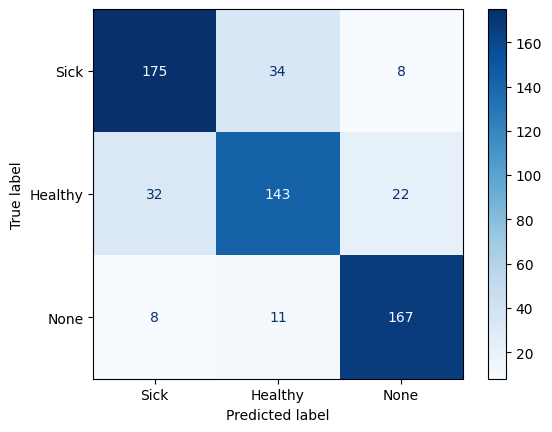

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sick', 'Healthy', 'None'])
disp.plot(cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report
class_names = ["sick", "healthy", "none"]
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        sick       0.81      0.81      0.81       217
     healthy       0.76      0.73      0.74       197
        none       0.85      0.90      0.87       186

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

